## Introduction to the problem and the data

The most pressing questions for banks are how efficiently can we guage the risk profile of our customers and how can we use this information to decide on the required liquidity while still maintaining our regulatory obligations.

With the constantly changing customer portfolio and the ever increasing customer base a more robust non-hardcoded approach is neccessary to achieve these antagonistic goals.

Thus comes the idea of using machine learning to develop a behavioural scorecard to pull data from both internal sources, customer transactions and their demographic data, to predict the probability of default.

In this notebook we are going to explore the data cleaning and transformation as well as machine learing modelling in predicting probability of default. We will then use these results to develop a credit rating.

The data that we will use is based on behaviourial and transactional data from bank customers who took loans in a certain product segment.
This is a secondary data, obtained from a local Bank in Kenya betweent the period 2021 - 2022


## Loading the Libs and the Data (And Getting to Know our Data)

In [ ]:
# Impoting general libraries
import warnings
import itertools
import random

# Data Analysis Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Data Preparation, Modeling, and Evaluation (SKLearn Modules)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer,OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler,RobustScaler, StandardScaler,  PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

# Class Imbalance
from imblearn.over_sampling import SMOTE

## Model Selection and Tuning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV


# Machine Learning Models
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Machine Learning Model Evaluation Methods
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

warnings.filterwarnings(action="ignore")
%matplotlib inline

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/okothchristopher/Machine-Learning-Projects/master/03.%20Week%203%20Classification%20Project%20-%20Credit%20Default%20Prediction/Classification%20Project%201/raw-data.csv')
# df.head()

## Preliminary Processing

In [ ]:
#Renaming columns in the dataset with their correct names
df = df.rename(columns={'V1': 'Customer ID',
'V2': 'Customer has bounced in first EMI',
'V3': 'No of times bounced 12 months',
'V4': 'Maximum MOB',
'V5': 'No of times bounced while repaying the loan',
'V6': 'EMI',
'V7': 'Loan Amount',
'V8': 'Tenure',
'V9': 'Dealer codes from where customer has purchased the Two wheeler',
'V10': 'Product code of Two wheeler',
'V11': 'No of advance EMI paid',
'V12': 'Rate of interest',
'V13': 'Gender',
'V14': 'Employment type',
'V15': 'Resident type of customer',
'V16': 'Date of birth',
'V17': 'Customer age when loanwas taken',
'V18': 'No of loans',
'V19': 'No of secured loans',
'V20': 'No of unsecured loans',
'V21': 'Max amount sanctioned in the Live loans',
'V22': 'No of new loans in last 3 months',
'V23': 'Total sanctioned amount in the secured Loans which are Live',
'V24': 'Total sanctioned amount in the unsecured Loans which are Live',
'V25': 'Maximum amount sanctioned for any Two wheeler loan',
'V26': 'Time since last Personal loan taken (in months)',
'V27': 'Time since first consumer durables loan taken (in months)',
'V28': 'No of times 30 days past due in last 6 months',
'V29': 'No of times 60 days past due in last 6 months',
'V30': 'No of times 90 days past due in last 3 months',
'V31': 'Tier',
'V32': 'Target variable'})
# df.head()

In [ ]:
#standardizing column names for easier usage
df.columns=df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.head(1)

,customer_id,customer_has_bounced_in_first_emi,no_of_times_bounced_12_months,maximum_mob,no_of_times_bounced_while_repaying_the_loan,emi,loan_amount,tenure,dealer_codes_from_where_customer_has_purchased_the_two_wheeler,product_code_of_two_wheeler,...,total_sanctioned_amount_in_the_secured_loans_which_are_live,total_sanctioned_amount_in_the_unsecured_loans_which_are_live,maximum_amount_sanctioned_for_any_two_wheeler_loan,time_since_last_personal_loan_taken_in_months,time_since_first_consumer_durables_loan_taken_in_months,no_of_times_30_days_past_due_in_last_6_months,no_of_times_60_days_past_due_in_last_6_months,no_of_times_90_days_past_due_in_last_3_months,tier,target_variable
0,1,0,0,24.0,0.0,2432.0,46500.0,24.0,1385.0,SC,...,NaN,NaN,46500.0,NaN,NaN,0,0,0,TIER 1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119528 entries, 0 to 119527
Data columns (total 32 columns):
 #   Column                                                          Non-Null Count   Dtype  
---  ------                                                          --------------   -----  
 0   customer_id                                                     119528 non-null  int64  
 1   customer_has_bounced_in_first_emi                               119528 non-null  int64  
 2   no_of_times_bounced_12_months                                   119528 non-null  int64  
 3   maximum_mob                                                     85048 non-null   float64
 4   no_of_times_bounced_while_repaying_the_loan                     85048 non-null   float64
 5   emi                                                             85048 non-null   float64
 6   loan_amount                                                     85048 non-null   float64
 7   tenure                                

In [ ]:
df.describe()

,customer_id,customer_has_bounced_in_first_emi,no_of_times_bounced_12_months,maximum_mob,no_of_times_bounced_while_repaying_the_loan,emi,loan_amount,tenure,dealer_codes_from_where_customer_has_purchased_the_two_wheeler,no_of_advance_emi_paid,...,no_of_new_loans_in_last_3_months,total_sanctioned_amount_in_the_secured_loans_which_are_live,total_sanctioned_amount_in_the_unsecured_loans_which_are_live,maximum_amount_sanctioned_for_any_two_wheeler_loan,time_since_last_personal_loan_taken_in_months,time_since_first_consumer_durables_loan_taken_in_months,no_of_times_30_days_past_due_in_last_6_months,no_of_times_60_days_past_due_in_last_6_months,no_of_times_90_days_past_due_in_last_3_months,target_variable
count,119528.000000,119528.000000,119528.000000,85048.000000,85048.000000,85048.000000,85048.000000,85048.000000,85048.000000,85048.000000,...,119528.0,1.928100e+04,1.902800e+04,104467.000000,13431.000000,20433.000000,119528.000000,119528.000000,119528.000000,119528.000000
mean,59764.500000,0.028378,0.473061,17.217148,0.690857,2325.701298,39338.081648,21.060048,3512.692233,0.643930,...,0.0,4.302522e+05,1.766494e+05,41415.210047,46.980940,48.208976,1.076877,0.823991,0.344898,0.021869
std,34504.905825,0.166052,0.859042,5.203209,1.091658,575.614365,11016.619745,5.698900,3754.675342,0.969123,...,0.0,8.228143e+05,4.075618e+05,13044.008078,42.716225,41.713826,3.737882,3.172612,1.478180,0.146258
min,1.000000,0.000000,0.000000,2.000000,0.000000,681.000000,10000.000000,6.000000,1001.000000,0.000000,...,0.0,9.900000e+01,1.000000e+00,10000.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000
25%,29882.750000,0.000000,0.000000,14.000000,0.000000,1895.000000,30000.000000,18.000000,1368.000000,0.000000,...,0.0,4.490000e+04,3.394050e+04,31000.000000,20.000000,23.000000,0.000000,0.000000,0.000000,0.000000
50%,59764.500000,0.000000,0.000000,17.000000,0.000000,2320.000000,39700.000000,24.000000,2307.000000,0.000000,...,0.0,1.100000e+05,8.800000e+04,42250.000000,31.000000,35.000000,0.000000,0.000000,0.000000,0.000000
75%,89646.250000,0.000000,1.000000,21.000000,1.000000,2689.000000,48000.000000,24.000000,3911.000000,1.000000,...,0.0,4.920000e+05,2.000048e+05,49300.000000,52.000000,55.000000,0.000000,0.000000,0.000000,0.000000
max,119528.000000,1.000000,12.000000,36.000000,29.000000,7840.000000,96000.000000,36.000000,21106.000000,6.000000,...,0.0,2.022777e+07,3.000000e+07,700000.000000,252.000000,268.000000,314.000000,243.000000,96.000000,1.000000


### Insights from Basic Data Analysis:
1. We have around 119k observations and a number of columns have missing values, we will explore these further and determine the missingneess characteristic and treat them accordingly.
2. We  have some features that are categorical data and some are numerical
3. Label is a discrete variable (classification problem) - We will explore the distribution of the target variable.
4. We have some extra features which are not relevent for building a machine learning model (need to remove them) - Like Customer ID

In [ ]:
# Remove extraneous columns
df.drop(['customer_id','date_of_birth'], axis=1, inplace=True)

# Separating the numerical variables from the categorical variables, in case we need to treat them separately
num_var=df.select_dtypes(include=[np.number])
cat_var=df.select_dtypes(include=[object])

In [ ]:
# cat_var.head()
# num_var.head()

## EDA

Text(0.5, 1.0, 'Missing Values Heatmap')

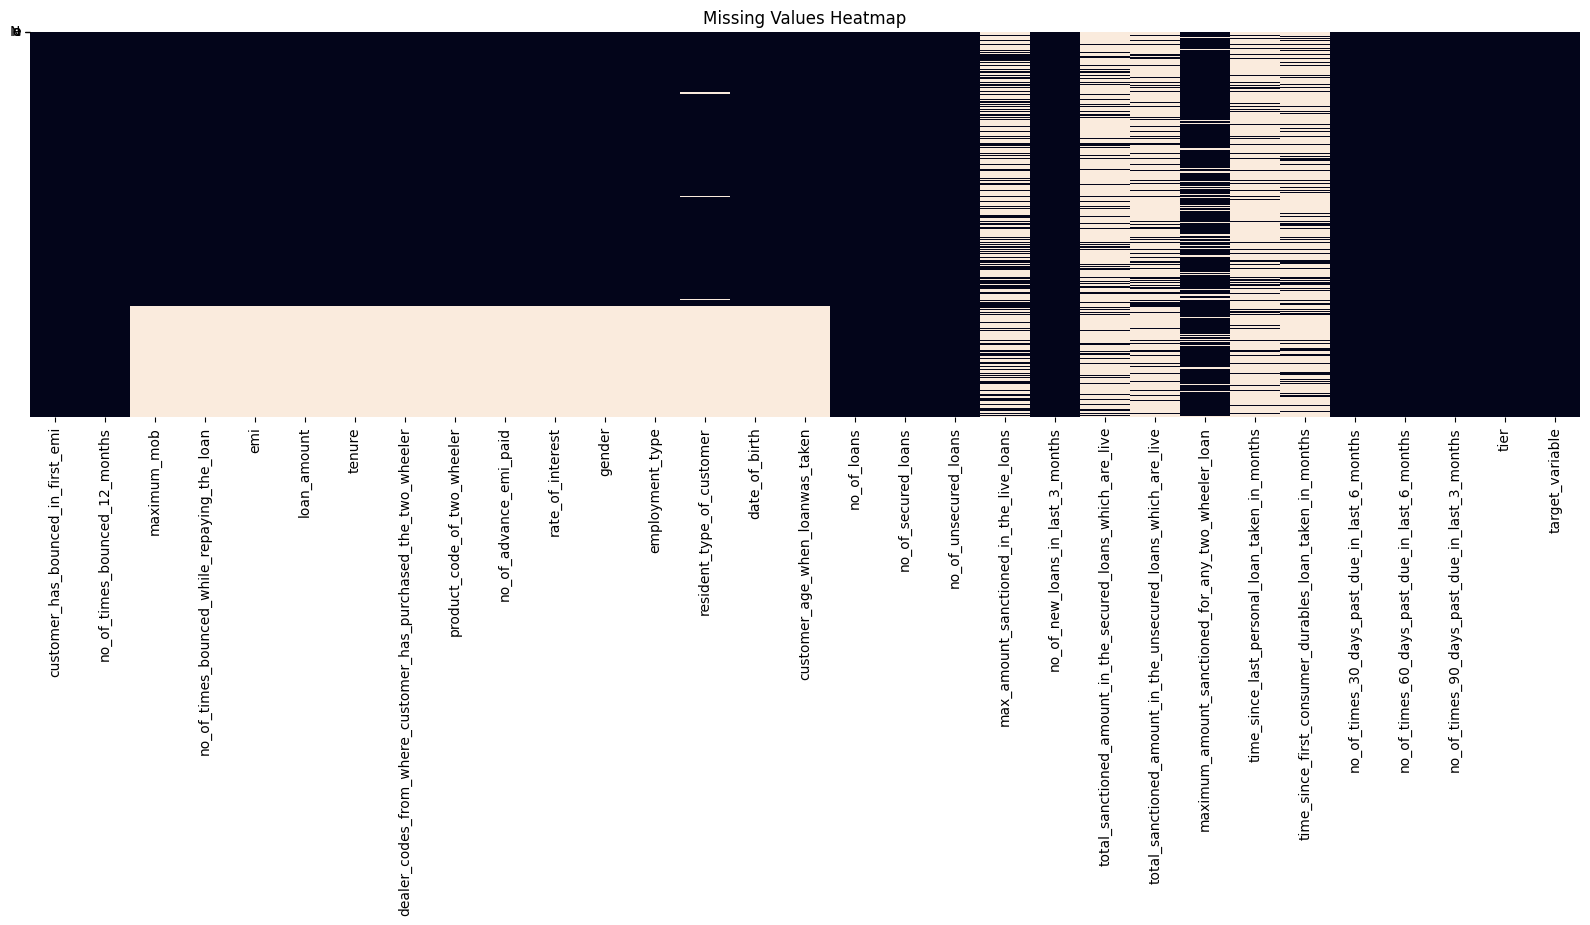

In [ ]:
## Start by exploring missiness
plt.figure(figsize=(20,5))

sns.heatmap(df.isnull(), yticklabels="None", cbar=False)
plt.title("Missing Values Heatmap")

#### Deductions /Insights
- We have columns with more than 50% in missing values - here we will drop the columns because they are not going to contribute to our model's discrimination fo the two classes.
- We also have a set of observations/customers with missing values all through: We will delete the rows with missing observations in these sections
- We have others that are missing in isolation, MAR - We will impute with median/mean depending on the number of outliers detected, then we will impute the missingess in the categorical columns with mode.

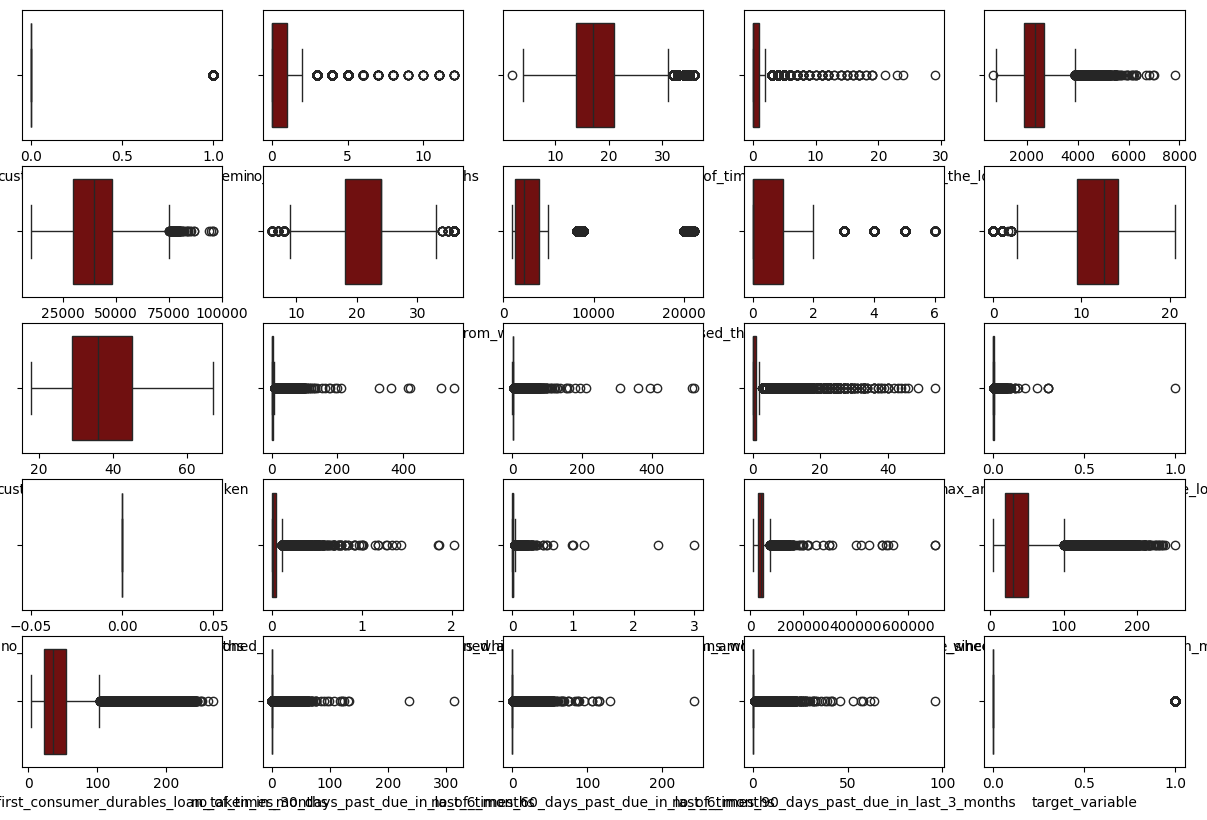

In [ ]:
## Explore presecence of outliers
# Unitvariate analysis of all the numerical variables - we are trying to see if there are outliers.
fig = plt.figure(figsize=(30,40))
for i,j in zip(num_var,range(len(num_var.columns))):
    ax = fig.add_subplot(10,5, j+1)
    sns.boxplot(data=df,x=df[i],orient='v',color="Maroon")

### Insights from Exploratory Data Analysis:
1. Most of the numerical variables have outliers
2. **Inituition:** We will need a model that is to outliers or may need to treat the outliers, before modelling

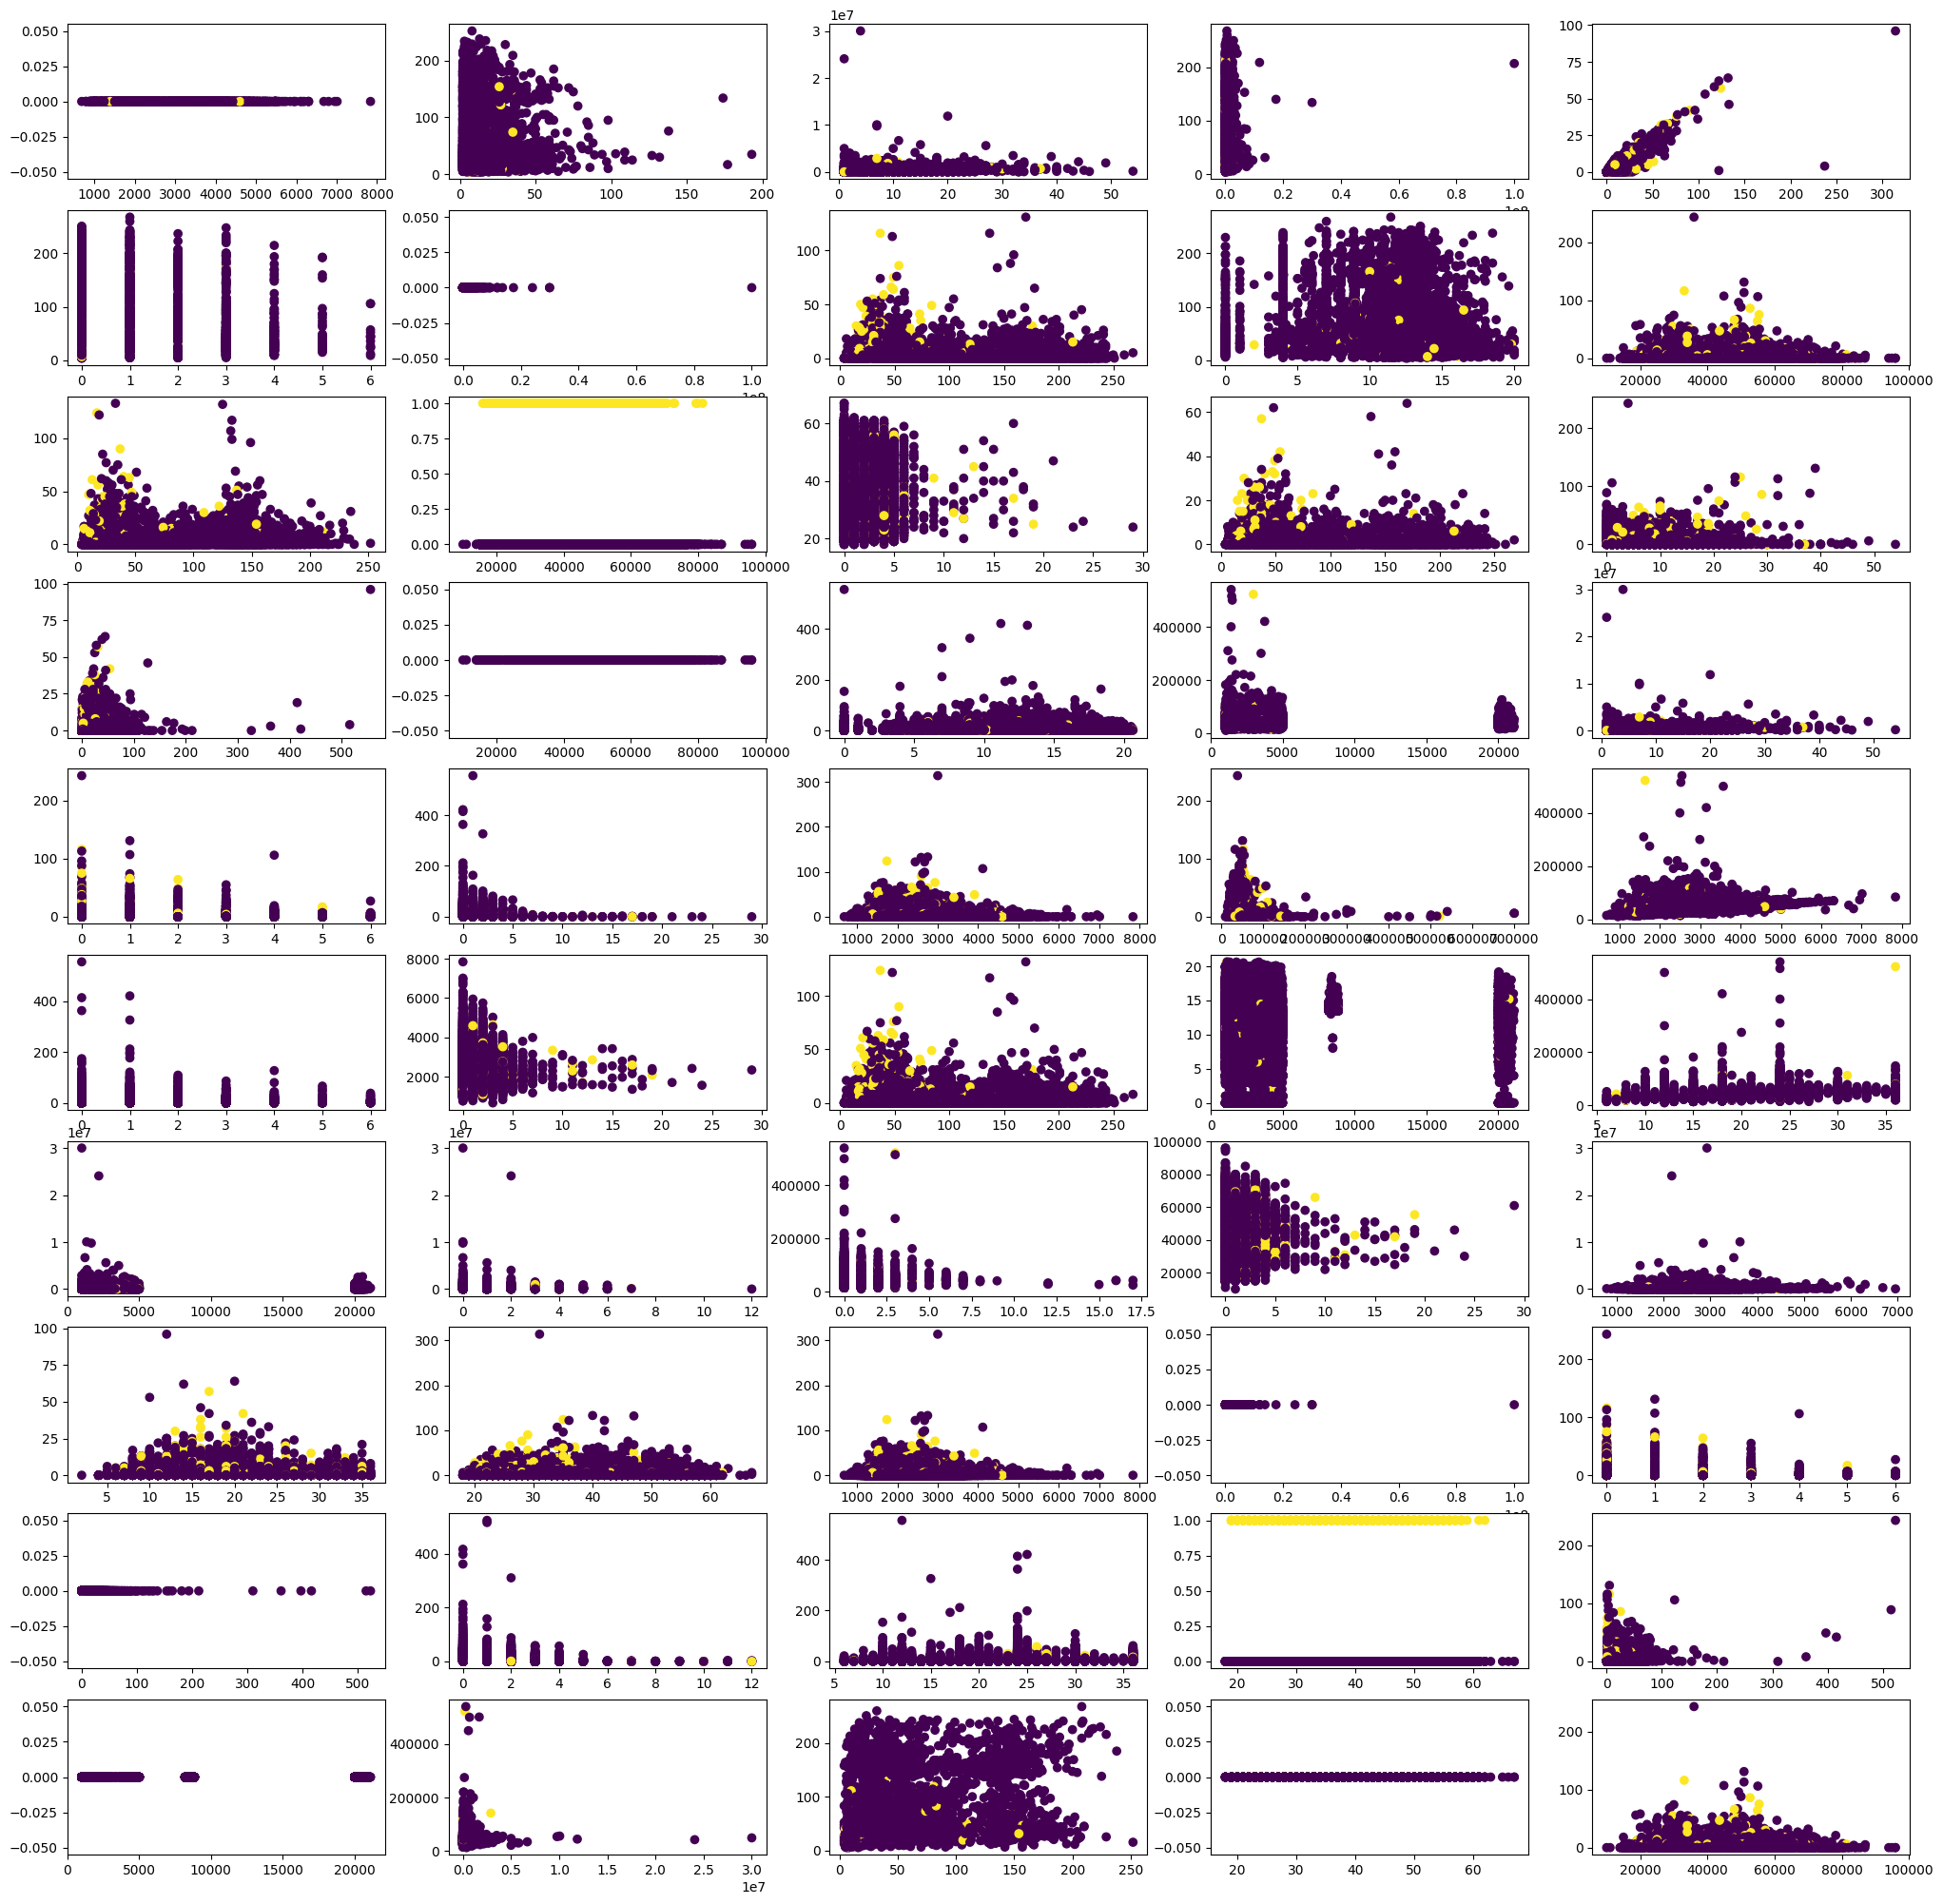

In [ ]:
### Linear Seperability

#Bivariate Data Analysis (Scatter Plots)
comb = list(itertools.combinations([a for a in range(1, len(num_var.columns))], 2)) #Create combinations of all features, in twos (bivariate)
rand = random.choices(comb, k=50) #Randomly choose 50 bivariate relationships to visualise. Total bivariate relationships (465 = 30C2) is too much
df['target_variable'] = df['target_variable'].astype('int') # Convert our tarrget variable to categorical because it is classification.

fig = plt.figure(figsize=(25,25))
for i in range(len(rand)):
    ax = fig.add_subplot(10,5, i+1)
    plt.scatter(num_var[num_var.columns[rand[i][0]]],num_var[num_var.columns[rand[i][1]]],c=df.target_variable)


### Insights / Deduction
1. Most data features are not linearly separable for the classification problem as seen from bivariate scatter plots
2. **Inituition:** Support Vector Machines and Ensemble Methods would probably be the models for this data as they can work non-linear separations

Text(0.5, 1.0, 'Ratio of Customers Who Defaulted and Who did Not')

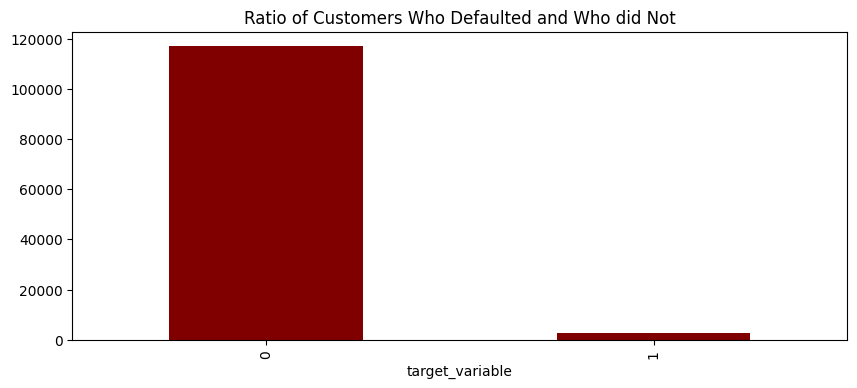

In [ ]:
### Class Imbalance/Lack of it thereof.
df.target_variable.value_counts().plot(kind = "bar", figsize = (10,4),color='Maroon')
plt.title("Ratio of Customers Who Defaulted and Who did Not")

### Insights
- Most people actually pay their loans and defaulters form less than 10% of the data.
- This is a classic case of class imbalance - We are going to generate synthetic data to compensate for the minority class using the SMOTE algo.
- We will also try other methods of class imbalance handling - i.e random oversampling of the minority class, randomg undersampling of the majority class and we will check how this afffects the model performance.

## Data Prep

In [ ]:
## Missing values
# For columns with more than 50% missing we are going to delete
df.dropna(thresh=df.shape[0]*0.5,axis=1, inplace = True)

## For other colums we are doing a mean for nume and mode for the cat
fill = dict()

for i in range(len(df.columns)):

    if df.columns[i] in num_var:
        fill[df.columns[i]] = df[df.columns[i]].mean()

    else:
        fill[df.columns[i]] = str(df[df.columns[i]].mode()).split()[1]

print(len(fill))
df = df.fillna(value=fill)


30


In [ ]:
## Ecoding
col_tr = make_column_transformer((OrdinalEncoder(),['tier']),(OneHotEncoder(), ['product_code_of_two_wheeler','gender','employment_type','resident_type_of_customer']), remainder="passthrough")
df_transformed = col_tr.fit_transform(df)

print(df_transformed.shape)

(119528, 41)


In [ ]:
pd.DataFrame(df_transformed).head(1)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,430252.2253,176649.426109,46500.0,46.98094,48.208976,0.0,0.0,0.0,0.0


In [ ]:
X = df_transformed[:,:40]
y = df.target_variable
print(X.shape,y.shape)


(119528, 40) (119528,)


In [ ]:
## Class Imbalance
# Smote - Synthetic Minority Oversampling Technique

smote_sample=SMOTE(random_state=124,sampling_strategy='auto')
X, y=smote_sample.fit_resample(X,y)


## Model Selection

In [ ]:
#Train Test Split: Reserve 30% of data for final model testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(163679, 40) (70149, 40) (163679,) (70149,)


In [ ]:
#Logistic Regression (No Regularisation)
pipe = make_pipeline(PolynomialFeatures(degree=1), LogisticRegression(penalty='none', solver='lbfgs'))
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.53512952 0.53702346 0.53146383 0.53375489 0.53031923] 0.5335381862123056


In [ ]:
# Support vector classification - RBF Kernel
pipe = make_pipeline(PolynomialFeatures(degree=1), SVC(kernel='rbf',C=5))
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
print(scores, scores.mean())

In [ ]:
# classification - Random Forest
pipe = make_pipeline(PolynomialFeatures(degree=1),RandomForestClassifier())
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
print(scores, scores.mean())

## Model Evaluation and Error Analysis

In [ ]:
# Investigating whether class imbalance has impacted our models.
model = RandomForestClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

matrix = confusion_matrix(y_test, y_pred)

#Visualise the matrix
plt.figure(figsize=(10,5))
sns.heatmap(matrix, annot=True, cmap='Blues')
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.title("Confusion Matrix for Model We have Selected to Tune")
plt.show()

matrix

## Model Hyperparameter Tuning